Go zemame GPT modelot od prethodnata glava kako model na koj ke se pravat evaluacii

In [9]:
import torch
import torch.nn as nn

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec


In [11]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [12]:
class LayerNormalization(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5 #sprecuva delenje so 0
     #parametri koi ucat dodeka se trenira, so nivna promena se podobruva modelot.
    self.scale = nn.Parameter(torch.ones(emb_dim)) #inicijalno postaven na 1, so nego se mnozi i se menuva vrednosta vo zavisnost od modelot
    self.shift = nn.Parameter(torch.zeros(emb_dim)) #inicijalno 0, so nego se dodava i se menuva vrednosta ....
  def forward(self,x):
     mean = x.mean(dim=-1, keepdim=True) #prosek na tensorot
     var = x.var(dim=-1, keepdim=True, unbiased=False) #varijansa
     norm_x = (x - mean) / torch.sqrt(var + self.eps) #normalizacija so pomos na formula
     return self.scale * norm_x + self.shift #vklucuvanje na parametrite


In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention( #specificiranje na parametrite za multiheadattention
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg) #povik na feedforward
        self.norm1 = LayerNormalization(cfg["emb_dim"]) #normalizacija pred self attention
        self.norm2 = LayerNormalization(cfg["emb_dim"]) #normalizacija pred feed forward
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"]) #dropout

    def forward(self, x):

        shortcut = x #zacuvuvanje na originalniot tensor x vo shortcut
        x = self.norm1(x) #normaliziranje na tensorot pred attention layer
        x = self.att(x) #attention layer
        x = self.drop_shortcut(x) #dropout layer
        x = x + shortcut  # dodavanje na originalniot tensor vo x za da se zacuva primarniot input

        shortcut = x  #povtorno zacuvuvanje na tensor pominat preku attention layer i shortcut
        x = self.norm2(x) #normalizacija pred feed forward
        x = self.ff(x) #feed forward
        x = self.drop_shortcut(x) #dropout layer
        x = x + shortcut #dodavanje na tensorot pominat preku att za da se zacuva primarnata informacija
        return x



In [14]:

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]) #tokenizacija
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) #positional embedding
        self.drop_emb = nn.Dropout(cfg["drop_rate"]) #dropout

        self.trf_blocks = nn.Sequential( #sekvencijalno povikuvanje na transformeri spored brojor na layers
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNormalization(cfg["emb_dim"]) #posledna normalizacija pred izlez
        self.out_head = nn.Linear( #linearen izlez
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape #gi zem goleminata na batchot i sekvencta od dimenziite na tensorot
        tok_embeds = self.tok_emb(in_idx) #embeding na tokenot

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device)) #poziciski embeding
        x = tok_embeds + pos_embeds #tensor od positional embeding i tokenizacija sto go dava semantickoto znacenje
        x = self.drop_emb(x) #dropout
        x = self.trf_blocks(x) #povik na transformation blocks
        x = self.final_norm(x) #posledna normalizacija pred output
        logits = self.out_head(x) #output
        return logits

In [15]:

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)


In [16]:
!pip install tiktoken
import tiktoken


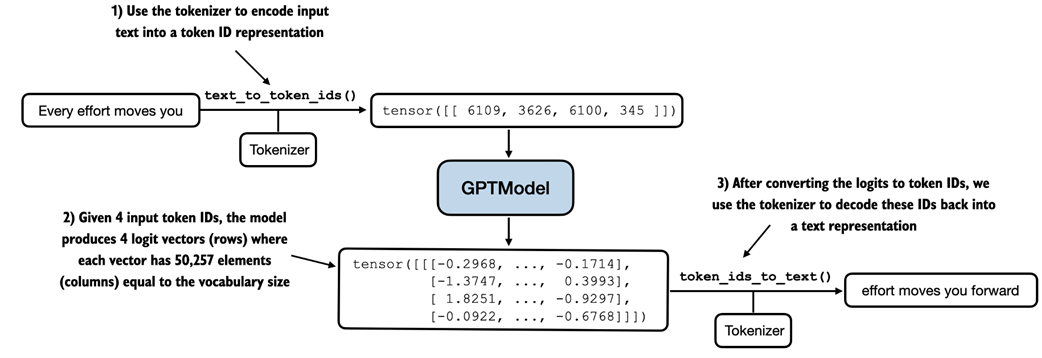

In [17]:
tokenizer=tiktoken.get_encoding("gpt2")

In [18]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'}) #enkodiraj
    #print("Encoded tokens:", encoded)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # dodadi dimenzija za da stane matrica
   # print("Encoded tensor:", encoded_tensor)
    return encoded_tensor

In [19]:
text="Every effort moves you"
text_to_token_ids(text,tokenizer)


tensor([[6109, 3626, 6100,  345]])

In [20]:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # tuka transformira od matrica vo 1D
    return tokenizer.decode(flat.tolist())

Od prethodnata nedela ja importitam generate_text_sample

In [21]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens): #vrti za da generira onolku zborovi kolku sto se baraat
        idx_cond = idx[:, -context_size:] #go zema posledniot token od idx za da napravi predviduvanje so pomos na nego
        with torch.no_grad():
            logits = model(idx_cond) #se dobivaat logits za sledniot token

        logits = logits[:, -1, :] #od logits go zema posledniot za da go predivi sledniot zbor so negova pomos
        probas = torch.softmax(logits, dim=-1) #so softmax presmetuva verojatnosti na logitsot
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) #koristi greedy bidejki go bira zborot so najgolema verojatnost
        idx = torch.cat((idx, idx_next), dim=1) #go konkatanira zborot so najgolema verojantost vo sekvencata od zborovi

    return idx

In [22]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youEvery feminists Sadfellipes Being accumulation Burn famousMine


# Loss metrika

Primer:

In [23]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

Presmetuvame softmax odnosno verojatnosti za sleden token na inputs. Ke vidime dali ke se poklopi so targets

In [24]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Verojatnosta na sekoj token
print(probas)
print(probas.shape)

tensor([[[1.8556e-05, 1.4356e-05, 3.2151e-05,  ..., 2.2854e-05,
          8.5592e-06, 1.4912e-05],
         [7.4780e-06, 1.4608e-05, 1.2764e-05,  ..., 2.5483e-05,
          5.2477e-06, 1.3517e-05],
         [2.3566e-05, 1.5398e-05, 2.1695e-05,  ..., 2.3610e-05,
          2.2156e-05, 1.3579e-05]],

        [[1.7814e-05, 1.8621e-05, 1.1877e-05,  ..., 7.7685e-06,
          2.9506e-05, 1.4106e-05],
         [7.0081e-06, 1.4404e-05, 8.9987e-06,  ..., 1.4245e-05,
          9.9755e-06, 1.4299e-05],
         [1.7761e-05, 3.8223e-05, 3.0670e-05,  ..., 6.0273e-06,
          8.1257e-05, 1.3114e-05]]])
torch.Size([2, 3, 50257])


Dimenzijata e 2 (golemina na batch odnosno 2 recenici), 3(broj na tokeni odnosno 3 zbora po recenica) i 50257 brojot na zborovi vo vokabularot od koi se bira

In [25]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[50153],
         [36902],
         [44376]],

        [[49906],
         [19737],
         [23689]]])


Zborovite so najgolema verojatnost za sekoja pozicija

In [26]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  PRESIDENTanon inaction


In [27]:
print(f"Targets batch 2: {token_ids_to_text(targets[1], tokenizer)}")
print(f"Outputs batch 2: {token_ids_to_text(token_ids[1].flatten(), tokenizer)}")


Targets batch 2:  really like chocolate
Outputs batch 2:  pressuring metabolic storytelling


Zborovite ne soodvestvuvaat nitu imaat smisla so targetot. Ova e bidejki modelot ne e treniran.

In [28]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([6.0115e-05, 3.6635e-05, 8.0533e-06])
Text 2: tensor([1.3642e-05, 4.0929e-05, 6.6502e-06])


Verojatnosti na sekoj od zborovite vo targetot. Ovie vrednosti se mnogu mali, a celta ni e verojatnostite da bidat poblisku do 1.

In [29]:

# Combine the probabilities from both sequences
combined_probas = torch.cat((target_probas_1, target_probas_2))

# Compute the logarithm of these probabilities
log_probas = torch.log(combined_probas)
print(log_probas)


tensor([ -9.7192, -10.2145, -11.7294, -11.2023, -10.1037, -11.9209])


Polesno e da se raboti so logaritmi namesto samite vrednosti da se maksimiziraat, zatoa koristime log od vrednostite koi gi presmetavme(probas) i target vrednostite

In [30]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.8150)


Na site logaritmi od dvata batcha im se presmetuva prosek


In [31]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.8150)


Pretvaranjeto na prosekot od pozitivna vo negativna vrednost se narekuva cross entropija. Celta e ovaa cross entropija da se namaluva so sekoe izminuvanje

Celta e negativniot prosek na log verojatnostite da se dovede da e priblizen do 0 so treniranje na modelot. Momentalniot output na primerot e daleku od toa zatoa sto modelot ne e treniran.

In [32]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)


Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [33]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


Im pravime flatten zatoa sto ke ja povikame loss funkcijata koja bara specificni dimenzii

In [34]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8150)


Loss funckijata presmeta kolku negativniot log prosek na logitsot otstapuva od target vrednosta odnosno cross entropy loss.

So gotova funkcija go dobivme istoto sto go pravevme racno

# Training and validation set losses

Za treniranje ke se koristi tekstot the Verdict sto go koristev za sozdavanje na vokabular

In [35]:
file_path = "/content/drive/MyDrive/Praksa/the-Verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [36]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20495
Tokens: 5154


In [37]:
train_ratio = 0.90 #90% za training, 10% za testing odnosno validation
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

Od Chapter2 importirame create_dataloader_v1

In [38]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [39]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [40]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


Ova e ekvivalent so train_test_split vo Keras

In [41]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

Funkcija za presmetka na cross entropy loss na input i target

In [42]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan") #dokolku ne postoi data loader se vrakja not a number
    elif num_batches is None: #dokolku brojot na batchobi ne e kazan, se zema goleminata na data loaderot
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader)) #dokolku brojot na batches e kazan, se proveruva dali e pomal od data_loaderot
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device) # za sekoj batch se presmetuva loss
            total_loss += loss.item() #se dodava na sumata od total loss
        else:
            break
    return total_loss / num_batches #se presmetuva prosek od total loss i brojot na batches

Loader za primena na funckijata za presmetka na cross entropy

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.990050633748373
Validation loss: 11.019294738769531


Vrednostite se losi bidejki modelot ne e treniran. Do sega samo so napravivme e podelba na training i validation set i funkcija za presmetka na loss. Naredno ke trenirame vekje

# Treniranje na modelot

In [44]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], [] #listi vo koi ke se cuvaat losses
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() #postavi loss gradient na 0 posle sekoja epoha
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() #presmetaj loss na epohata
            optimizer.step() #apdejtiraj weights so loss gradient
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(#podole definirana
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample( #podole definirana
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

In [45]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [46]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [47]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.831, Val loss 9.953
Ep 1 (Step 000005): Train loss 8.118, Val loss 8.331
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000010): Train loss 6.773, Val loss 7.035
Ep 2 (Step 000015): Train loss 6.510, Val loss 6.549
Every effort moves you, and, and,, and, and,,,, and, and,, and,,,,, and,,,, and,,,, and,, and,,,,, and,, and,,,
Ep 3 (Step 000020): Train loss 5.673, Val loss 6.446
Ep 3 (Step 000025): Train loss 4.904, Val loss 6.414
Every effort moves you of theisburn, and, and---- the picture.                                     
Ep 4 (Step 000030): Train loss 5.430, Val loss 6.419
Ep 4 (Step 000035): Train loss 4.102, Val loss 6.273
Every effort moves you of the of the of the of the picture my of the of the of the of the of the of the picture. I had been the of the picture, and I had been the of the, and he was it was the of the picture of
Ep 5 (Step 000040): Train loss 3.904, Val loss 6.216
Every effort moves you know

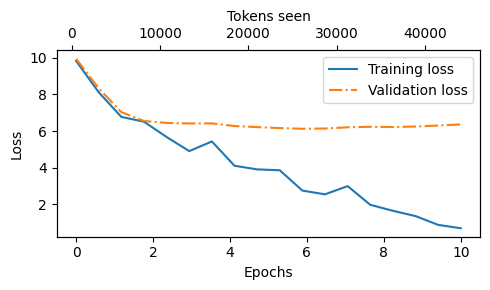

In [48]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

Training lossot posle sekoja epoha postepeno opagja sto znaci deka modelot uci, no validation lossot stagnira. Ova e zatoa sto datasetot na koj sto vezba modelot e mnogu mal i se slucuva overfitting

# Decoding strategies

In [49]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know."
"Has he chucked his pictures too? I felt nervous and uncertain.

"Once, when I looked up, I had made him--it was fitting that they should mourn him. Among his own sex fewer regrets were heard


Zabrzana verzija na gorniot kod kade sto se koristi generate_text_sample funkcijata, odnosno koristi greedy za da odbere koj zbor ke bide sledno generiran

# Temperature scaling

Za razlika od greedy, temperature scaling koristi

In [50]:
import torch
import torch.nn as nn

In [51]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


Tuka so greedy bese odbran zborot so najgolema verojatnost. Ova e poradi argmax funkcijata koja sekogas ke go odbere zborot so najgolema verojatnost.

In [52]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


Tuka bese odbran random zbor a ne zborot so najgolema verojatnost. So multinomial site zborovi imaat sansa da bidat izbrani, iako nekoi povekje od drugi, ne znaci deka sekoj pat se bira zborot so najgolema verojatnost.

In [53]:
probas

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])

In [54]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


Scenario kade sto od 1000 pati prikazuva kolku pati sekoj od zborovite e odbran. Iako forward e zbor so najgolema verojatnost ni prikazuva deka ne sekoj pat e toj odbran.

Tuka se voveduva konceptot na temperature scaling-tehnika koja ja odreduva razlicnosta na zborovite koi se generiraat namesto strogo da go bira zborot so najgolema verojatnost. Ako e temperature pogolema od 1 toa znaci deka ima pounificirana podelba,a ako e pomala od 1 znaci deka nema tolku razlicnost vo izborot. |

In [55]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

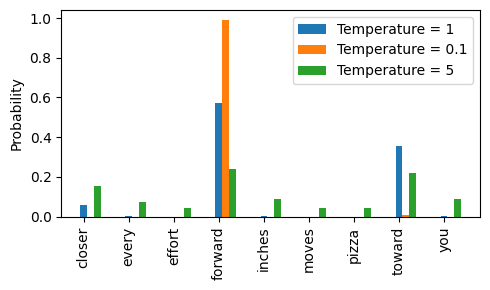

In [56]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)
#Temperatures greater than 1 result in more uniformly distributed token probabilities, and Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions. Let's illustrate this by plotting the original probabilities alongside probabilities scaled with different temperature values:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

Kolku e pogolem temperature tolku verojatnosta na zborovite e poslicna. Kolku e pomal temperature tolku verojatnosta na zborovite e poekstremna.

In [57]:
print_sampled_tokens(scaled_probas[1]) #so temp 0.1

0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward


In [58]:
print_sampled_tokens(scaled_probas[2]) #so temp 5

153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


# Top k sampling

Prodolzenie na temperature scaling, od tuka se odbiraat k zborovi so najgolema verojatnost i od niv se pravi temperaturno skaliranje.

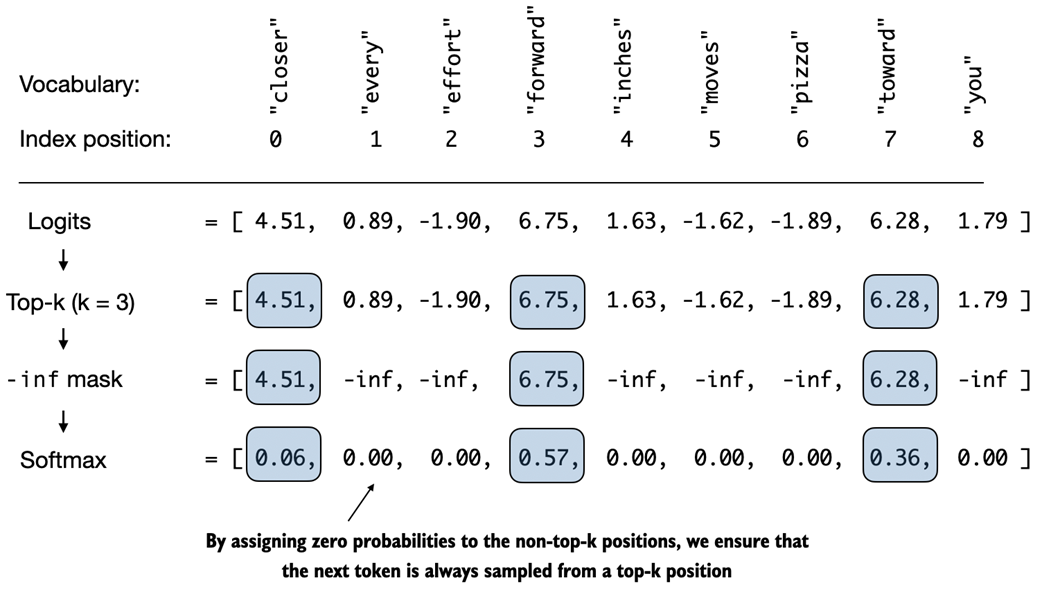

In [59]:
next_token_logits

tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])

In [60]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [61]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [62]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


# Promena na text generation funkcija


In [63]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # for ciklus za da se generiraat novi zborovi
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] #gi vadi poslednite context_size zborovi so pomos na koi ke se pravat predviduvanja
        with torch.no_grad():
            logits = model(idx_cond) #zema logits od poslednite context_size zborovi
        logits = logits[:, -1, :] #go zema posledniot logit,,,???

        # Pravi filtriranje so pomos na top_k
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k) #gi zema najgolemite k vrednosti od logitsot
            min_val = top_logits[:, -1] #od tie vrednosti ja selektira najmalata
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits) #za site vrednosti pomali od najmalata vo top k se stava -inf vrednost

        # Pravi randomizacija so temperatura
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # ako nema temp odbirame so arg max

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [64]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youany more than if I had married her so charming wild--oh face the


# Zacuvuvanje i loadiranje na prethodno definiran model

Za posle sekoja upotreba da ne mora da se ceka dolgo za da se loadira modelot, a sepak da gi ima nauceno weightsot od prethodni obidi vo PyTorch postoi opcija da se zacuva seto ona sto e prethodno definirano

In [65]:
torch.save(model.state_dict(), "model.pth")

kod za zacuvuvanje na model vo PyTorch

In [66]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

Otkako sme gi zacuvale weightsot na modelot mozeme povtorno da gi loadirame za pokratko vreme:

In [67]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNormalization()
      (norm2): LayerNormalization()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): 

Dokolku sakame da prodolzime so pretraining na modelot, dobro e da bidat zacuvani i sostojbite na optimizerot

In [68]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

Loadiranje na modelot:

In [69]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

# Loadiranje na pretrained model od OpenAI

Koristime gotov model od OpenAI koj e izvezban na pogolem broj na podatoci otkolku nasiot model gore.

In [70]:
pip install tensorflow>=2.15.0  tqdm>=4.66

In [71]:
import tensorflow as tf
import tqdm

print("TensorFlow version:", tf.__version__)
print("tqdm version:", tqdm.__version__)


TensorFlow version: 2.17.0
tqdm version: 4.66.4


In [72]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7b0e68f4cd00>)

In [73]:
from gpt_download import download_and_load_gpt2

In [74]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [75]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [76]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [77]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [78]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [79]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


load_weights_into_gpt(gpt, params)
gpt.to(device);

In [80]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the


Outputot od GPT2 modelot e podobar otkolku mojot output sto bese treniran na mal del podatoci. Toa e zatoa sto modelot e podobro izvezban

# Zadaci

1. Use the print_sampled_tokens function to print the sampling frequencies of the softmax probabilities scaled with the temperatures shown in Figure 5.13. How often is the word "pizza" sampled in each case? Can you think of a faster and more accurate way to determine how often the word "pizza" is sampled?

In [81]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()


In [82]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)


temperatures = [1, 0.1, 5]  # Original, higher, and lower temperature
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

In [83]:
for i, probas in enumerate(scaled_probas):
    print("\n\nTemperature:", temperatures[i])
    print_sampled_tokens(probas)



Temperature: 1
71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


Temperature: 0.1
0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward


Temperature: 5
153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


In [84]:
for i, probas in enumerate(scaled_probas):
    print("\n\nTemperature:", temperatures[i])
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
      if i==6:
        print(float(freq/1000))



Temperature: 1
0.0


Temperature: 0.1
0.0


Temperature: 5
0.0430000014603138


2. Play around with different temperatures and top-k settings. Based on your observations, can you think of applications where lower temperature and top-k settings are desired? Vice versa, can you think of applications where higher temperature and top-k settings are preferred? (It's recommended to also revisit this exercise at the end of the chapter after loading the pretrained weights from OpenAI.)

Poniska teperatura e posakuvana kade sto ni e potreben tocen zbor odnosno moze da se primeni kade sto ima missing words,testovi, kodovi (kaj sto se bara preciznost), a visoki temperaturi se primenuvaat vo slucai kade sto sakame povekje razlicnost kako sto se kreativni tekstovi.

In [85]:
torch.manual_seed(123)


token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Tennis, basketball and swimming are Olympic", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=5,
    temperature=0.2

)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Tennis, basketball and swimming are Olympic sports.

The Olympic Games are not a sport for the faint of heart. The Olympics are a sport for the rich


In [86]:
torch.manual_seed(123)


token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Tennis, basketball and swimming are Olympic", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=20
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Tennis, basketball and swimming are Olympic challenges worthy a sport for a young coach not already capable
"A school football has lost that game a season to any form


3. What are the different combinations of settings for the generate function to force deterministic behavior, that is, disabling the random sampling such that it always produces the same outputs similar to the generate_simple function?

  So far, we covered how to pretrain LLMs and use them to generate text. The last two sections of this chapter will discuss how we save and load the trained LLM and how we load pretrained weights from OpenAI.

Postavuvanje na niska temperatura i mala vrednost za top_k odnosno top_k=1 za 1 odgovor i temperature=0

In [87]:
torch.manual_seed(123)


token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Tennis, basketball and swimming are Olympic", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=1,
    temperature=0
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Tennis, basketball and swimming are Olympic sports.

The Olympic Games are held every four years in Rio de Janeiro, Brazil.

The Games are held


4. After saving the weights, load the model and optimizer in a new Python session or Jupyter notebook file and continue pretraining it for 1 more epoch using the train_model_simple function.

In [88]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = tiktoken.get_encoding("gpt2")

checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

In [ ]:
import os
import urllib.request


file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()


In [ ]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]



In [91]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [92]:
import requests

url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_train.py"
response = requests.get(url)

with open("gpt_train.py", "wb") as file:
    file.write(response.content)


In [93]:
#from gpt_train import train_model_simple
"""
num_epochs = 1
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)
"""

'\nnum_epochs = 1\ntrain_losses, val_losses, tokens_seen = train_model_simple(\n    model, train_loader, val_loader, optimizer, device,\n    num_epochs=num_epochs, eval_freq=5, eval_iter=5,\n    start_context="Every effort moves you", tokenizer=tokenizer\n)\n'

5. Calculate the training and validation set losses of the GPTModel with the pretrained weights from OpenAI on the "The Verdict" dataset.

In [94]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [95]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [97]:
file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()


# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [100]:


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader
train_loss = calc_loss_loader(train_loader, gpt, device)
val_loss = calc_loss_loader(val_loader, gpt, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.754749059677124
Validation loss: 3.5596208572387695


6.Readers are encouraged to experiment with GPT-2 models of different sizes, for example, the largest 1558M parameter model and compare the generated text to the 124M model we loaded in this chapter.

In [ ]:
model_name = "gpt2-xl (1558M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))